In [46]:
!pip install tensorflow

  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/252.7 MB 12.6 MB/s eta 0:00:0000:0100:01
Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 12.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 12.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.4/670.4 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 12.5 MB/s eta 0:00:00a 0:00:01
Using cached tensorboard_data_server-0.7.2-py3-none-any.whl (2.4 kB)
Using cached nam

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
#importing data
df=pd.read_csv("Netflix_Dataset.csv",index_col='Date')
df

,Open,High,Low,Close,Volume
Date,,,,,
04-03-2019,359.72,362.25,348.04,351.04,"74,86,996"
05-03-2019,351.46,356.17,348.25,354.30,"59,37,754"
06-03-2019,353.60,359.88,351.70,359.61,"62,11,895"
07-03-2019,360.16,362.86,350.50,352.60,"61,51,331"
08-03-2019,345.75,349.92,342.47,349.60,"68,98,838"
...,...,...,...,...,...
25-02-2022,386.61,391.29,375.58,390.80,"48,41,636"
28-02-2022,387.33,397.75,382.13,394.52,"50,35,046"
01-03-2022,391.60,395.00,383.71,386.24,"32,90,439"


In [25]:
#data cleaning
df.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 758 entries, 04-03-2019 to 03-03-2022
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    758 non-null    float64
 1   High    758 non-null    float64
 2   Low     758 non-null    float64
 3   Close   758 non-null    float64
 4   Volume  758 non-null    object 
dtypes: float64(4), object(1)
memory usage: 35.5+ KB


In [27]:
df["Volume"] = df["Volume"].str.replace(",", "").astype(int)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 758 entries, 04-03-2019 to 03-03-2022
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    758 non-null    float64
 1   High    758 non-null    float64
 2   Low     758 non-null    float64
 3   Close   758 non-null    float64
 4   Volume  758 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 35.5+ KB


In [29]:
df[df.duplicated()]

,Open,High,Low,Close,Volume
Date,,,,,


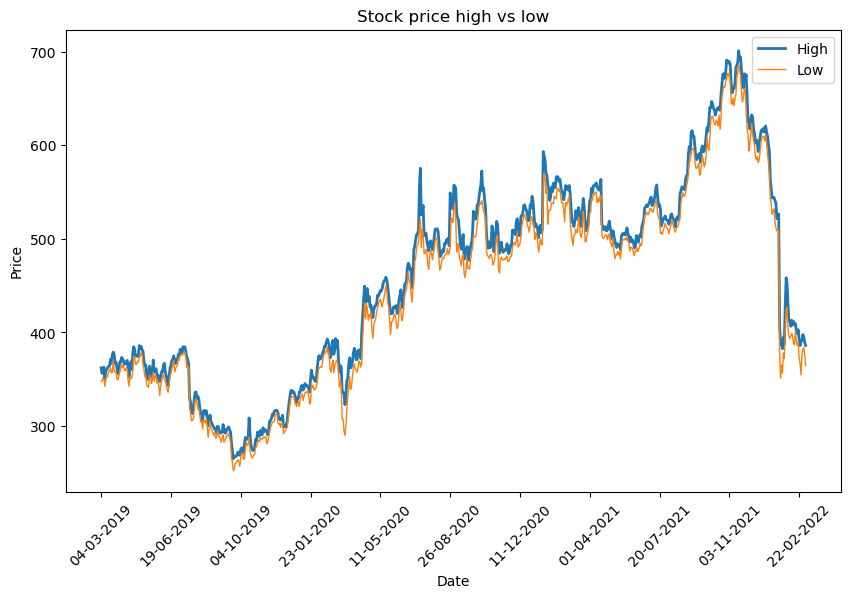

In [30]:
#data visulization
plt.figure(figsize=(10,6))
plt.plot(df['High'],label='High',linewidth=2)
plt.plot(df['Low'],label='Low',linewidth=1)
plt.title('Stock price high vs low')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.xticks(df.index[::len(df)//10])
plt.show()

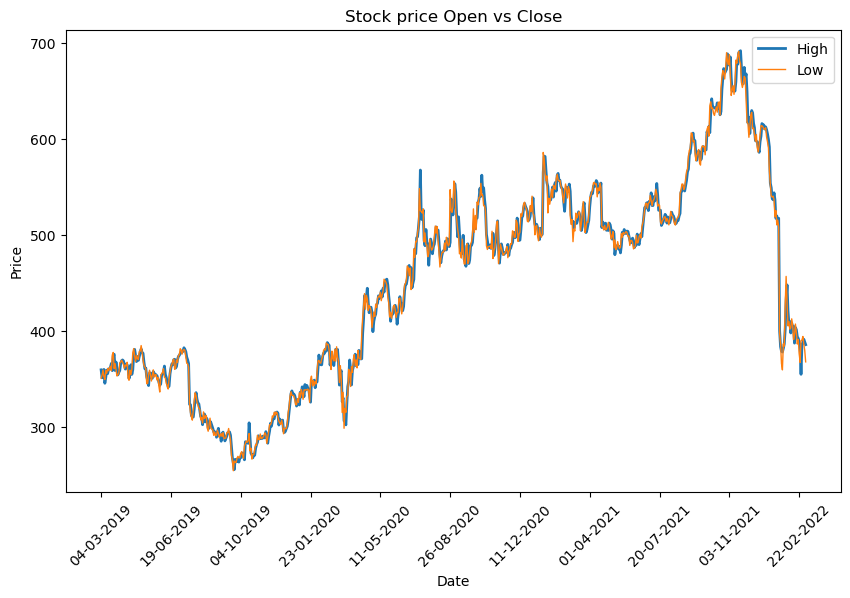

In [31]:
plt.figure(figsize=(10,6))
plt.plot(df['Open'],label='High',linewidth=2)
plt.plot(df['Close'],label='Low',linewidth=1)
plt.title('Stock price Open vs Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.xticks(df.index[::len(df)//10])
plt.show()

In [36]:
#Data preprocessing 
stock_data=df[['Open','High','Low','Close']]

In [38]:
#Feature Scaling
sc=StandardScaler()
Stk_data_ft=sc.fit_transform(stock_data.values)

stk_data_ft=pd.DataFrame(columns=stock_data.columns,data=Stk_data_ft,index=stock_data.index)

In [40]:
def lstm_split(data,n_steps):
    X,y=[],[]
    for i in range(len(data)-n_steps):
        X.append(data[i:i+n_steps,:-1])
        y.append(data[i+n_steps-1,-1])
    return np.array(X),np.array(y)

In [44]:
#Split data
X1,y1=lstm_split(stk_data_ft.values,n_steps=1)
train_split=0.8
split_idx = int(np.ceil(len(X1) * train_split))
date_index=stk_data_ft.index
X_train,X_test=X1[:split_idx],X1[split_idx:]
y_train,y_test=y1[:split_idx],y1[split_idx:]

X_train_date,X_test_date=date_index[:split_idx],date_index[split_idx:]
print(X1.shape,X_train.shape,X_test.shape,y_test.shape)

(757, 1, 3) (606, 1, 3) (151, 1, 3) (151,)


In [49]:
lstm=Sequential()
lstm.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error',optimizer='adam')
lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 1, 32)          │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1, 1)           │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,641 (18.13 KB)

 Trainable params: 4,641 (18.13 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
#Fit model
history=lstm.fit(X_train,y_train,epochs=100,batch_size=4,validation_split=0.2,verbose=2,shuffle=False)

Epoch 1/100
121/121 - 1s - 5ms/step - loss: 0.6300 - val_loss: 0.2495
Epoch 2/100
121/121 - 0s - 689us/step - loss: 0.1408 - val_loss: 0.0420
Epoch 3/100
121/121 - 0s - 1ms/step - loss: 0.0138 - val_loss: 0.0088
Epoch 4/100
121/121 - 0s - 719us/step - loss: 0.0134 - val_loss: 0.0085
Epoch 5/100
121/121 - 0s - 702us/step - loss: 0.0132 - val_loss: 0.0085
Epoch 6/100
121/121 - 0s - 695us/step - loss: 0.0130 - val_loss: 0.0085
Epoch 7/100
121/121 - 0s - 684us/step - loss: 0.0128 - val_loss: 0.0086
Epoch 8/100
121/121 - 0s - 679us/step - loss: 0.0127 - val_loss: 0.0086
Epoch 9/100
121/121 - 0s - 677us/step - loss: 0.0125 - val_loss: 0.0087
Epoch 10/100
121/121 - 0s - 682us/step - loss: 0.0124 - val_loss: 0.0088
Epoch 11/100
121/121 - 0s - 678us/step - loss: 0.0123 - val_loss: 0.0089
Epoch 12/100
121/121 - 0s - 689us/step - loss: 0.0123 - val_loss: 0.0089
Epoch 13/100
121/121 - 0s - 678us/step - loss: 0.0122 - val_loss: 0.0090
Epoch 14/100
121/121 - 0s - 691us/step - loss: 0.0122 - val_loss

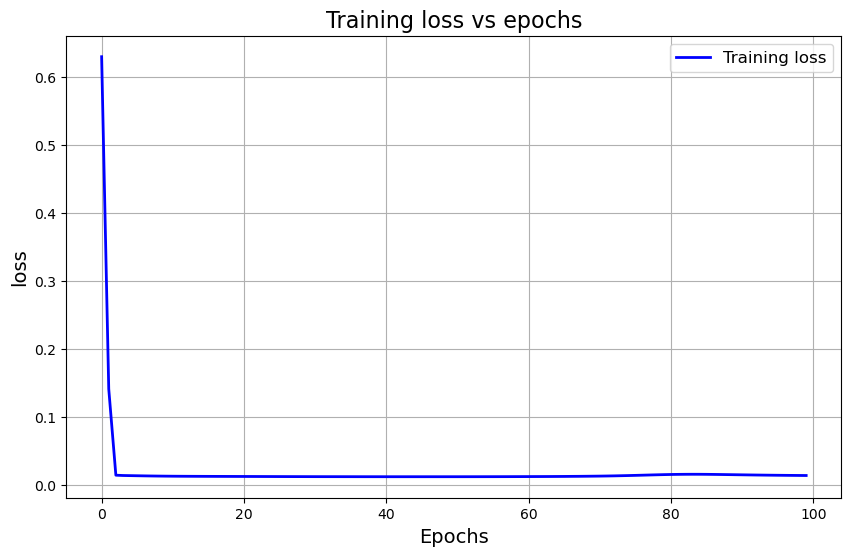

In [51]:
#plotting training loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'],label='Training loss',color='blue',linewidth=2)
plt.title('Training loss vs epochs',fontsize=16)
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('loss',fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [52]:
#Testing the model
y_pred=lstm.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


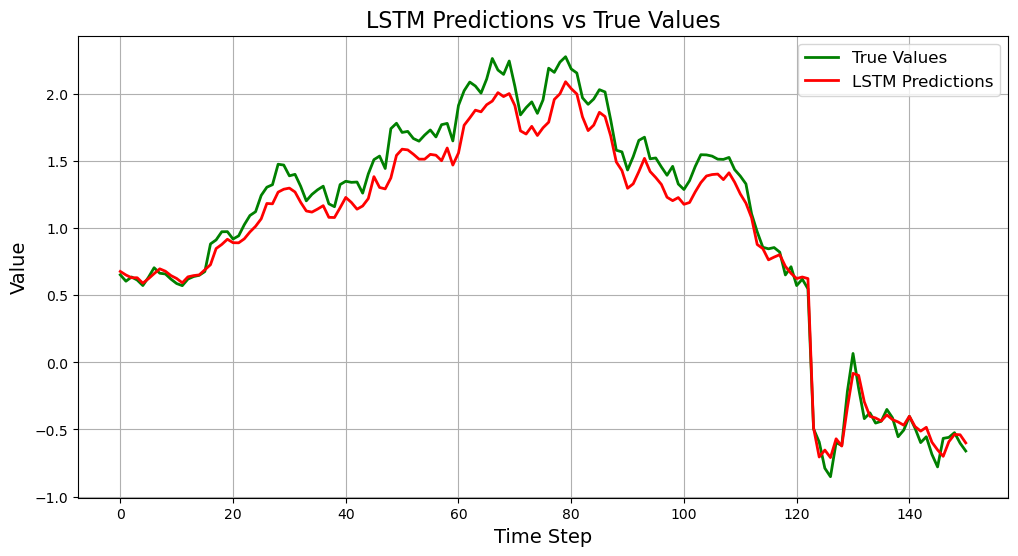

In [53]:
y_test_flat=y_test.squeeze()
y_pred_flat=y_pred.squeeze()
plt.figure(figsize=(12,6))
plt.plot(y_test_flat,label='True Values',color='green',linewidth=2)
plt.plot(y_pred_flat,label='LSTM Predictions',color='red',linewidth=2)
plt.title('LSTM Predictions vs True Values',fontsize=16)
plt.xlabel('Time Step',fontsize=14)
plt.ylabel('Value',fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [54]:
mse=mean_squared_error(y_test,y_pred_flat)
rmse=np.sqrt(mse)
mape=mean_absolute_percentage_error(y_test,y_pred_flat)
print('RMSE:',rmse)
print('mape:',mape)

RMSE: 0.14419236166120603
mape: 0.11148520056679172


In [55]:
#Adding another layer of LSTM
lstm=Sequential()
lstm.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
lstm.add(LSTM(50,activation='relu',return_sequences=True))
lstm.add(LSTM(50,activation='relu'))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error',optimizer='adam')
lstm.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1, 32)          │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1, 50)          │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,459 (161.95 KB)

 Trainable params: 41,459 (161.95 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
history=lstm.fit(X_train,y_train,epochs=100,batch_size=4,validation_split=0.2,verbose=2,shuffle=False)
y_pred=lstm.predict(X_test)

Epoch 1/100
121/121 - 1s - 11ms/step - loss: 0.7507 - val_loss: 0.5626
Epoch 2/100
121/121 - 0s - 1ms/step - loss: 0.1275 - val_loss: 0.1792
Epoch 3/100
121/121 - 0s - 1ms/step - loss: 0.0329 - val_loss: 0.0047
Epoch 4/100
121/121 - 0s - 1ms/step - loss: 0.0283 - val_loss: 0.0034
Epoch 5/100
121/121 - 0s - 1ms/step - loss: 0.0259 - val_loss: 0.0030
Epoch 6/100
121/121 - 0s - 1ms/step - loss: 0.0229 - val_loss: 0.0031
Epoch 7/100
121/121 - 0s - 1ms/step - loss: 0.0202 - val_loss: 0.0032
Epoch 8/100
121/121 - 0s - 1ms/step - loss: 0.0185 - val_loss: 0.0032
Epoch 9/100
121/121 - 0s - 1ms/step - loss: 0.0170 - val_loss: 0.0032
Epoch 10/100
121/121 - 0s - 1ms/step - loss: 0.0157 - val_loss: 0.0032
Epoch 11/100
121/121 - 0s - 1ms/step - loss: 0.0146 - val_loss: 0.0030
Epoch 12/100
121/121 - 0s - 1ms/step - loss: 0.0136 - val_loss: 0.0029
Epoch 13/100
121/121 - 0s - 1ms/step - loss: 0.0128 - val_loss: 0.0027
Epoch 14/100
121/121 - 0s - 1ms/step - loss: 0.0121 - val_loss: 0.0026
Epoch 15/100
1

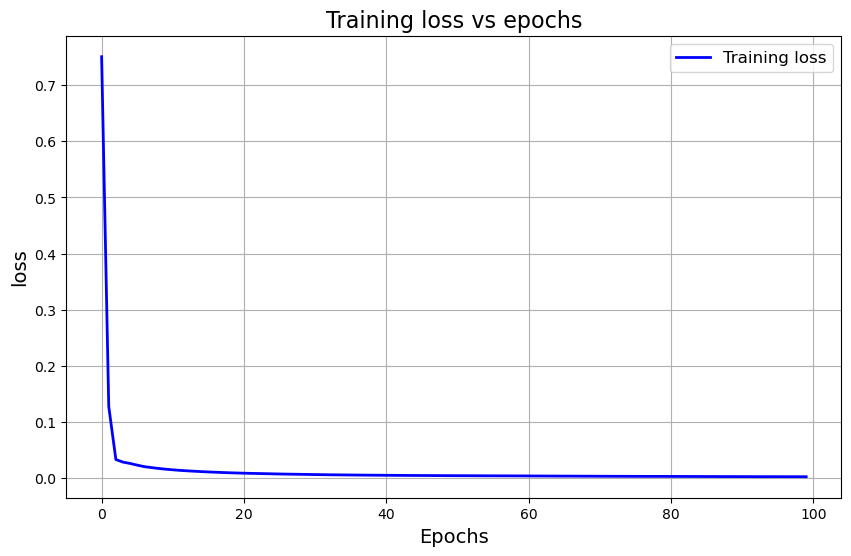

In [57]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'],label='Training loss',color='blue',linewidth=2)
plt.title('Training loss vs epochs',fontsize=16)
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('loss',fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

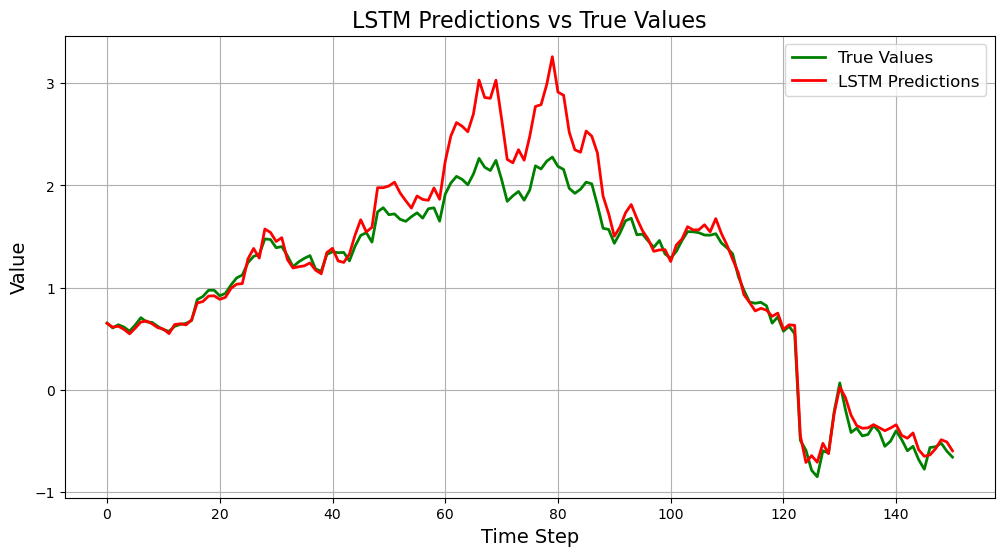

In [58]:
y_test_flat=y_test.squeeze()
y_pred_flat=y_pred.squeeze()
plt.figure(figsize=(12,6))
plt.plot(y_test_flat,label='True Values',color='green',linewidth=2)
plt.plot(y_pred_flat,label='LSTM Predictions',color='red',linewidth=2)
plt.title('LSTM Predictions vs True Values',fontsize=16)
plt.xlabel('Time Step',fontsize=14)
plt.ylabel('Value',fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [59]:
mse=mean_squared_error(y_test,y_pred_flat)
rmse=np.sqrt(mse)
mape=mean_absolute_percentage_error(y_test,y_pred_flat)
print('RMSE:',rmse)
print('mape:',mape)

RMSE: 0.26672632690926007
mape: 0.11767173753437121


In [60]:
#Assessing the model by changing the n_steps
X1,y1=lstm_split(stk_data_ft.values,n_steps=10)
train_split=0.8
split_idx = int(np.ceil(len(X1) * train_split))
date_index=stk_data_ft.index
X_train,X_test=X1[:split_idx],X1[split_idx:]
y_train,y_test=y1[:split_idx],y1[split_idx:]

X_train_date,X_test_date=date_index[:split_idx],date_index[split_idx:]
print(X1.shape,X_train.shape,X_test.shape,y_test.shape)

(748, 10, 3) (599, 10, 3) (149, 10, 3) (149,)


In [61]:
lstm=Sequential()
lstm.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
lstm.add(LSTM(50,activation='relu',return_sequences=True))
lstm.add(LSTM(50,activation='relu'))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error',optimizer='adam')
lstm.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 10, 32)         │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 10, 50)         │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,459 (161.95 KB)

 Trainable params: 41,459 (161.95 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
history=lstm.fit(X_train,y_train,epochs=100,batch_size=4,validation_split=0.2,verbose=2,shuffle=False)

Epoch 1/100
120/120 - 2s - 14ms/step - loss: 0.1653 - val_loss: 0.0622
Epoch 2/100
120/120 - 0s - 4ms/step - loss: 0.0923 - val_loss: 0.0281
Epoch 3/100
120/120 - 0s - 4ms/step - loss: 0.0455 - val_loss: 0.0256
Epoch 4/100
120/120 - 0s - 4ms/step - loss: 0.0422 - val_loss: 0.0313
Epoch 5/100
120/120 - 0s - 4ms/step - loss: 0.0355 - val_loss: 0.0264
Epoch 6/100
120/120 - 0s - 4ms/step - loss: 0.0354 - val_loss: 0.0254
Epoch 7/100
120/120 - 0s - 4ms/step - loss: 0.0326 - val_loss: 0.0239
Epoch 8/100
120/120 - 0s - 4ms/step - loss: 0.0299 - val_loss: 0.0221
Epoch 9/100
120/120 - 0s - 4ms/step - loss: 0.0282 - val_loss: 0.0211
Epoch 10/100
120/120 - 0s - 4ms/step - loss: 0.0265 - val_loss: 0.0192
Epoch 11/100
120/120 - 0s - 4ms/step - loss: 0.0252 - val_loss: 0.0166
Epoch 12/100
120/120 - 0s - 4ms/step - loss: 0.0237 - val_loss: 0.0132
Epoch 13/100
120/120 - 0s - 4ms/step - loss: 0.0231 - val_loss: 0.0106
Epoch 14/100
120/120 - 0s - 4ms/step - loss: 0.0217 - val_loss: 0.0088
Epoch 15/100
1

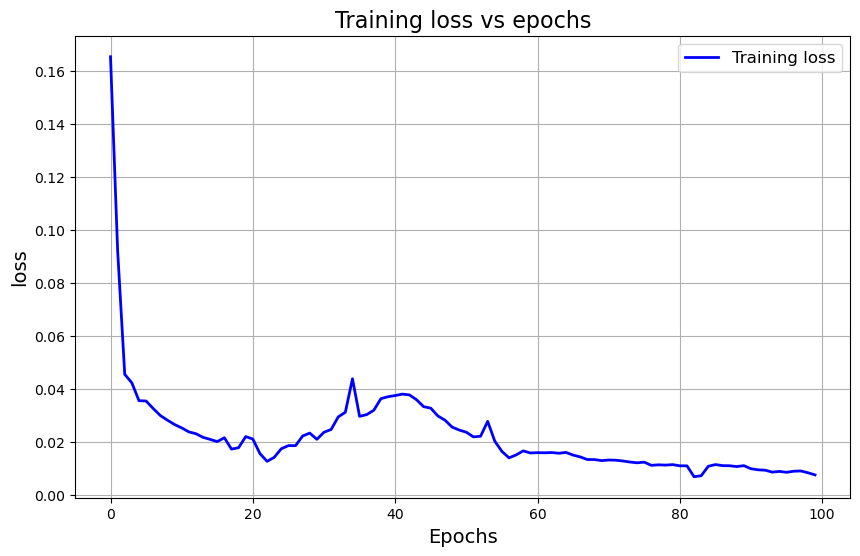

In [63]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'],label='Training loss',color='blue',linewidth=2)
plt.title('Training loss vs epochs',fontsize=16)
plt.xlabel('Epochs',fontsize=14)
plt.ylabel('loss',fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [67]:
y_pred=lstm.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


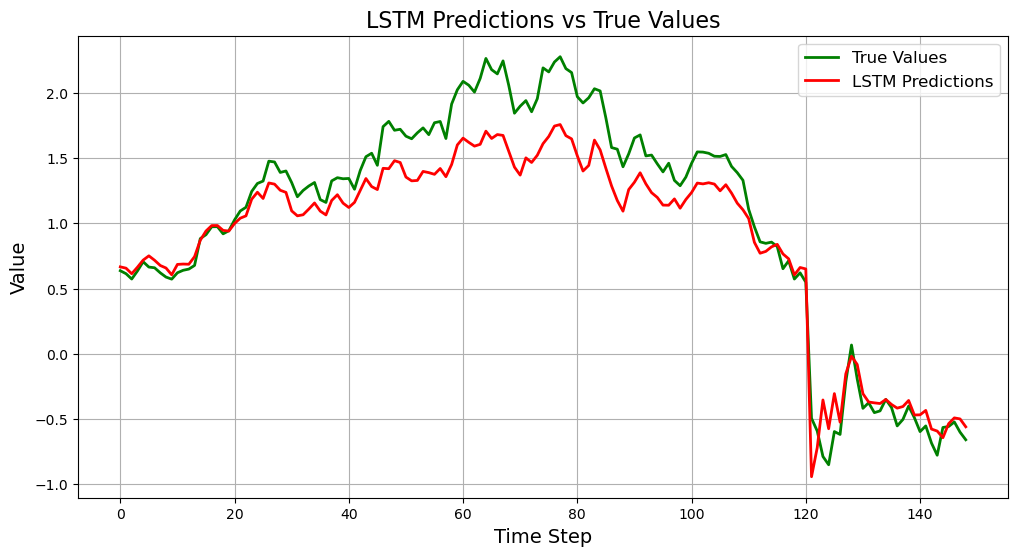

In [68]:
y_test_flat=y_test.squeeze()
y_pred_flat=y_pred.squeeze()
plt.figure(figsize=(12,6))
plt.plot(y_test_flat,label='True Values',color='green',linewidth=2)
plt.plot(y_pred_flat,label='LSTM Predictions',color='red',linewidth=2)
plt.title('LSTM Predictions vs True Values',fontsize=16)
plt.xlabel('Time Step',fontsize=14)
plt.ylabel('Value',fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [69]:
mse=mean_squared_error(y_test,y_pred_flat)
rmse=np.sqrt(mse)
mape=mean_absolute_percentage_error(y_test,y_pred_flat)
print('RMSE:',rmse)
print('mape:',mape)

RMSE: 0.2688842179397739
mape: 0.1679673248478704


Test RMSE: 100.354
Test MAPE: 0.163


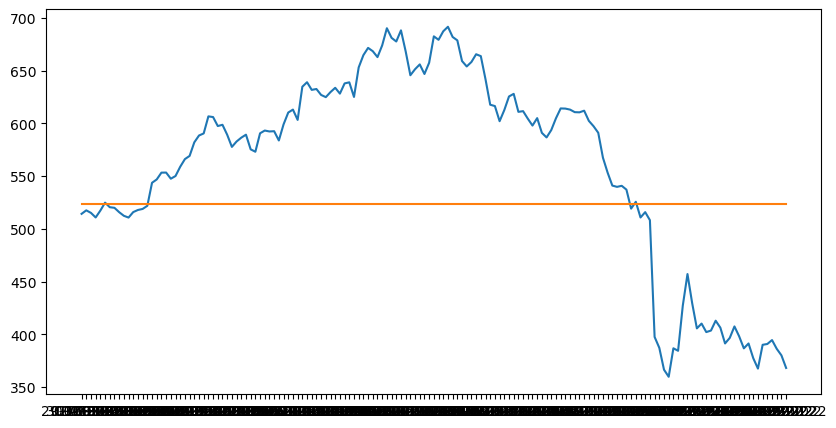

In [70]:
#Simple Moving Average
train_split=0.8
split_idx = int(np.ceil(len(stock_data) * train_split))

train=stock_data[['Close']].iloc[:split_idx]
test=stock_data[['Close']].iloc[split_idx:]
test_pred=np.array([train.rolling(10).mean().iloc[-1]]*len(test)).reshape((-1,1))
print('Test RMSE: %0.3f' %np.sqrt(mean_squared_error(test,test_pred)))
print('Test MAPE: %0.3f' %mean_absolute_percentage_error(test,test_pred))
plt.figure(figsize=(10,5))
plt.plot(test)
plt.plot(test_pred)
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimiz

Test RMSE: 100.244
Test MAPE: 0.163


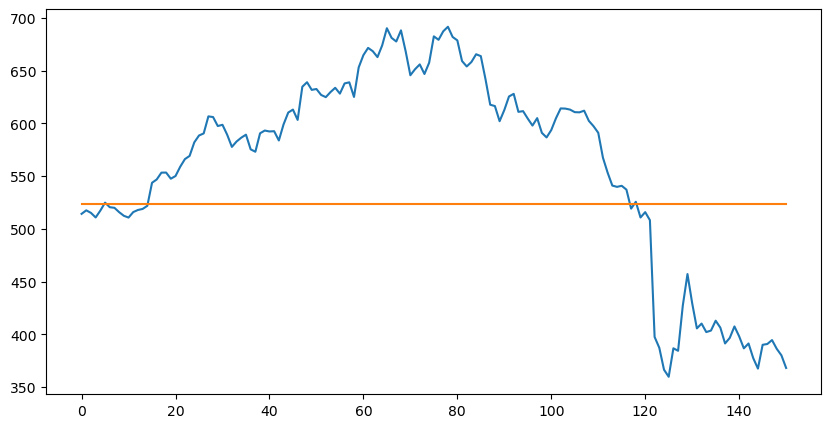

In [72]:
#Exponential Moving average
from statsmodels.tsa.api import SimpleExpSmoothing
X=stock_data[['Close']].values
train_split=0.8
split_idx=int(np.ceil(len(X)*train_split))
train=X[:split_idx]
test=X[split_idx:]
test_concat=np.array([]).reshape((0,1))
for i in range(len(test)):
    train_fit=np.concatenate((train,np.asarray(test_concat)))
    fit=SimpleExpSmoothing(np.asarray(train_fit)).fit(smoothing_level=0.1)
    test_pred=fit.forecast(1)
    test_concat=np.concatenate((np.asarray(test_concat),test_pred.reshape((-1,1))))

print('Test RMSE: %0.3f' %np.sqrt(mean_squared_error(test,test_concat)))
print('Test MAPE: %0.3f' %mean_absolute_percentage_error(test,test_concat))
plt.figure(figsize=(10,5))
plt.plot(test)
plt.plot(test_concat)
plt.show()